In [ ]:
#link my Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 # load Boston House data set
import pandas as pd
import numpy as np

raw_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/boston.csv', header=None)
data_rows = np.reshape(raw_data.to_numpy(), (506,14))
data = data_rows[:,:13]
target = data_rows[:,13]

# normalize input features to zero-mean and unit-variance
data = (data-np.mean(data, axis=0))/np.std(data, axis=0) 

print(data.shape)
print(target.shape)

(506, 13)
(506,)


In [ ]:
# add a constant column of '1' to accomodate the bias 
data_wb = np.hstack((data, np.ones((data.shape[0], 1), dtype=data.dtype)))

print(data_wb.shape)

# refer to the closed-form solution
w = np.linalg.inv(data_wb.T @ data_wb) @ data_wb.T @ target

# calculate the mean square error in the training set
predict = data_wb @ w 
error = np.sum((predict - target)*(predict - target))/data.shape[0]

print(f'mean square error for the closed-form solution: {error:.3f}')

(506, 14)
mean square error for the closed-form solution: 21.895


In [3]:
# solve ridge regression using gradient descent 
import numpy as np

class Optimizer():
  def __init__(self, rr, annealing_rate, batch_size, max_epochs):
    self.rr = rr
    self.annealing_rate = annealing_rate
    self.batch_size = batch_size
    self.max_epochs = max_epochs

def ridge_regression_gd(X, y, op):
  n = X.shape[0]   # number of samples
  w = np.zeros(X.shape[1])  # initialization

  rr = op.rr
  errors = np.zeros(op.max_epochs)
  for epoch in range(op.max_epochs):
    indices = np.random.permutation(n)  #randomly shuffle data indices
    for batch_start in range(0, n, op.batch_size):
      X_batch = X[indices[batch_start:batch_start + op.batch_size]]
      y_batch = y[indices[batch_start:batch_start + op.batch_size]]

      # vectorization to compute gradients for a whole mini-batch (see the above formula)
      w_grad = X_batch.T @ X_batch @ w - X_batch.T @ y_batch 

      w -= rr * w_grad / X_batch.shape[0]

    diff = X @ w - y  # prediction difference
    errors[epoch] = np.sum(diff*diff)/n
    rr *= op.annealing_rate
    #print(f'epoch={epoch}: the mean square error is {errors[epoch]}')

  return w, errors

In [4]:
import matplotlib.pyplot as plt

op = Optimizer(rr=0.001, annealing_rate=0.99, batch_size=30, max_epochs=500)

w, errors = ridge_regression_gd(data_wb, target, op)

plt.title('A larger mini-batch; converging smoothly but still a gap')
plt.xlabel('number of epoches')
plt.plot(errors, 'b', 21.89*np.ones(errors.shape[0]), 'c--')
plt.legend(['gradient descent', 'closed-form solution'])

NameError: name 'ridge_regression_gd' is not defined

In [2]:
import numpy as np
from sklearn import ridge_model
from sklearn.metrics import mean_squared_error

# Create ridge regression object
r_regr = ridge_model.ridgeRegression()

# Train the model using the training set
r_regr.fit(data_wb, target)

# Make predictions using the same training set
predict = r_regr.predict(data_wb)

# The mean squared error
print("Mean squared error: %.5f" % mean_squared_error(target, predict))

NameError: name 'data_wb' is not defined

## **II. Linear Regression for Classification**

### **Example 2.2:**

Use lasso regression to build a binary classifier to classify two digits ('3' and '8') in the MNIST data set. Consider to use both the closed-form solution and an iterative method to fit to the data and discuss their pros and cons with experimental results.

In [ ]:
# install python_mnist

!pip install python_mnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# install idx2numpy

!pip install idx2numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#load MINST images

import idx2numpy
#from mnist import MNIST
import numpy as np

train_data = idx2numpy.convert_from_file('/content/drive/My Drive/Colab Notebooks/datasets/MNIST/train-images.idx3-ubyte')
train_data = np.reshape(train_data,(60000,28*28))
train_label = idx2numpy.convert_from_file('/content/drive/My Drive/Colab Notebooks/datasets/MNIST/train-labels.idx1-ubyte')
test_data=idx2numpy.convert_from_file('/content/drive/My Drive/Colab Notebooks/datasets/MNIST/t10k-images.idx3-ubyte')
test_data = np.reshape(test_data,(10000,28*28))
test_label = idx2numpy.convert_from_file('/content/drive/My Drive/Colab Notebooks/datasets/MNIST/t10k-labels.idx1-ubyte') 
train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_label = np.array(test_label, dtype='short')

#add small random noise to avoid matrix singularity
train_data += np.random.normal(0,0.0001,train_data.shape) 

print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [ ]:
# prepare digits '3' and '8' for linear regression

digit_train_index = np.logical_or(train_label == 3, train_label == 8)
X_train = train_data[digit_train_index]
y_train = train_label[digit_train_index]
digit_test_index = np.logical_or(test_label == 3, test_label == 8)
X_test = test_data[digit_test_index]
y_test = test_label[digit_test_index]

# add a constant column of '1' to accomodate the bias (see the margin note on page 107)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1), dtype=X_train.dtype)))
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1), dtype=X_test.dtype)))

# convert labels: '3' => -1, '8' => +1
CUTOFF = 5 # any number between '3' and '8'
y_train = np.sign(y_train-CUTOFF)
y_test = np.sign(y_test-CUTOFF)

print(X_train.shape)
print(y_train)

print(X_test.shape)
print(y_test)

(11982, 785)
[-1 -1 -1 ...  1 -1  1]
(1984, 785)
[-1 -1 -1 ... -1  1 -1]


In [ ]:
# use the closed-form solution

# refer to the closed-form solution, i.e. Eq.(6.9) on page 112
w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

# calculate the mean square error and classification accuracy on the training set
predict = X_train @ w 
error = np.sum((predict - y_train)*(predict - y_train))/X_train.shape[0]
print(f'mean square error on training data for the closed-form solution: {error:.5f}')

accuracy = np.count_nonzero(np.equal(np.sign(predict),y_train))/y_train.size*100.0
print(f'classification accuracy on training data for the closed-form solution: {accuracy:.2f}%')

# calculate the mean square error and classification accuracy on the test set
predict = X_test @ w 
error = np.sum((predict - y_test)*(predict - y_test))/X_test.shape[0]
print(f'mean square error on test data for the closed-form solution: {error:.5f}')

accuracy = np.count_nonzero(np.equal(np.sign(predict),y_test))/y_test.size*100.0
print(f'classification accuracy on test data for the closed-form solution: {accuracy:.2f}%')

mean square error on training data for the closed-form solution: 0.19562
classification accuracy on training data for the closed-form solution: 96.98%
mean square error on test data for the closed-form solution: 0.46899
classification accuracy on test data for the closed-form solution: 95.82%


In [ ]:
# use lasso regression from sklearn

import numpy as np
from sklearn import lasso_model
from sklearn.metrics import mean_squared_error

# Create lasso regression object
l_regr = lasso_model.LinearRegression()

# Train the model using the training set
l_regr.fit(X_train, y_train)

# Make predictions using the same training set
predict = l_regr.predict(X_train)
print("Mean squared error on training data: %.5f" % mean_squared_error(y_train, predict))

# Make predictions using the test set
predict = l_regr.predict(X_test)
print("Mean squared error on test data: %.5f" % mean_squared_error(y_test, predict))

Mean squared error on training data: 0.19562
Mean squared error on test data: 0.46899


In [ ]:
# solve lasso regression using gradient descent 
import numpy as np

class Optimizer():
  def __init__(self, lr, annealing_rate, batch_size, max_epochs):
    self.lr = lr
    self.annealing_rate = annealing_rate
    self.batch_size = batch_size
    self.max_epochs = max_epochs

# X[N,d]: training features; y[N]: training targets; 
# X2[N,d]: test features; y2[N]: test targets;  
# op: hyper-parameters for optimzer 
#
# Note: X2 and y2 are not used in training
#       but only for computting the learning curve B
#
def lasso_regression_gd2(X, y, X2, y2, op):
  n = X.shape[0]   # number of samples
  w = np.zeros(X.shape[1])  # initialization

  lr = op.lr
  errorsA = np.zeros(op.max_epochs)
  errorsB = np.zeros(op.max_epochs)
  errorsC = np.zeros(op.max_epochs)

  for epoch in range(op.max_epochs):
    indices = np.random.permutation(n)  #randomly shuffle data indices
    for batch_start in range(0, n, op.batch_size):
      X_batch = X[indices[batch_start:batch_start + op.batch_size]]
      y_batch = y[indices[batch_start:batch_start + op.batch_size]]

      # vectorization to compute gradients for a whole mini-batch (see the above formula)
      w_grad = X_batch.T @ X_batch @ w - X_batch.T @ y_batch 

      w -= lr * w_grad / X_batch.shape[0] 

    # for learning curve C
    diff = X @ w - y  # prediction difference
    errorsC[epoch] = np.sum(diff*diff)/n   

    # for learning curve A
    predict = np.sign(X @ w)
    errorsA[epoch] = np.count_nonzero(np.equal(predict,y))/y.size 

    # for learning curve B
    predict2 = np.sign(X2 @ w)
    errorsB[epoch] = np.count_nonzero(np.equal(predict2,y2))/y2.size

    lr *= op.annealing_rate
    print(f'epoch={epoch}: the mean square error is {errorsC[epoch]:.3f} ({errorsA[epoch]:.3f},{errorsB[epoch]:.3f})')

  return w, errorsA, errorsB, errorsC

epoch=0: the mean square error is 0.399 (0.910,0.919)
epoch=1: the mean square error is 0.309 (0.929,0.942)
epoch=2: the mean square error is 0.279 (0.939,0.951)
epoch=3: the mean square error is 0.263 (0.944,0.957)
epoch=4: the mean square error is 0.254 (0.948,0.959)
epoch=5: the mean square error is 0.248 (0.951,0.961)
epoch=6: the mean square error is 0.244 (0.953,0.963)
epoch=7: the mean square error is 0.240 (0.954,0.964)
epoch=8: the mean square error is 0.238 (0.955,0.963)
epoch=9: the mean square error is 0.235 (0.956,0.964)
epoch=10: the mean square error is 0.234 (0.957,0.963)
epoch=11: the mean square error is 0.232 (0.957,0.964)
epoch=12: the mean square error is 0.231 (0.958,0.964)
epoch=13: the mean square error is 0.230 (0.958,0.964)
epoch=14: the mean square error is 0.229 (0.959,0.964)
epoch=15: the mean square error is 0.228 (0.959,0.963)
epoch=16: the mean square error is 0.227 (0.960,0.962)
epoch=17: the mean square error is 0.226 (0.959,0.964)
epoch=18: the mean s

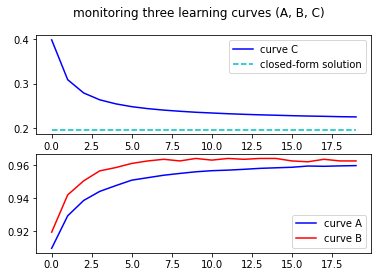

In [ ]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.001, annealing_rate=0.99, batch_size=50, max_epochs=20)

w, A, B, C = lasso_regression_gd2(X_train, y_train, X_test, y_test, op)

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, B, C)')
ax[0].plot(C, 'b', 0.196*np.ones(C.shape[0]), 'c--')
ax[0].legend(['curve C', 'closed-form solution'])

ax[1].plot(A, 'b', B, 'r')
ax[1].legend(['curve A', 'curve B'])

In [5]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.001, annealing_rate=0.99, batch_size=5, max_epochs=10)

w, A, B, C = lasso_regression_gd2(X_train, y_train, X_test, y_test, op)

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, B, C)')
ax[0].plot(C, 'b', 0.196*np.ones(C.shape[0]), 'c--')
ax[0].legend(['curve C', 'closed-form solution'])

ax[1].plot(A, 'b', B, 'r')
ax[1].legend(['curve A', 'curve B'])

NameError: name 'lasso_regression_gd2' is not defined